# Custom NER for Identifying Diseases and Treatments

This notebook implements a custom Named Entity Recognition (NER) system to identify diseases and treatments from a medical dataset. The dataset is provided in tokenized format, where each word is associated with a label:
- `O` indicates "Other"
- `D` indicates "Disease"
- `T` indicates "Treatment"

## Steps in this Notebook
1. **Data Preprocessing:** Reconstruct sentences and labels from the tokenized dataset.
2. **Concept Identification:** Identify key concepts in the dataset using PoS tagging.
3. **Defining Features for CRF:** Create features for training the CRF model.
4. **Getting Features for Words and Sentences:** Apply feature definitions to all sentences.
5. **Defining Input and Target Variables:** Prepare input features and labels for training and testing.
6. **Building the Model:** Train the CRF model on the training dataset.
7. **Evaluating the Model:** Evaluate the model on the test dataset using F1 score and classification metrics.
8. **Identifying Diseases and Predicted Treatments:** Extract relationships between diseases and treatments using the trained model.


In [16]:
# !pip install -q tabulate==0.9.0 spacy==3.8.3 sklearn-crfsuite==0.5.0

## Step 1: Data Preprocessing
The dataset is provided in tokenized format, where each word is stored on a separate line, and sentences are separated by blank lines. In this step, I will:
1. Reconstruct sentences and labels from the training and testing datasets.
2. Count the number of sentences and labels in the processed datasets.


In [17]:
# Paths to the dataset files
train_sent_path = 'data/train_sent'
train_label_path = 'data/train_label'
test_sent_path = 'data/test_sent'
test_label_path = 'data/test_label'

In [18]:
def process_data(file_path):
    """
    Read a dataset file and reconstruct sentences or labels.

    Parameters:
    file_path (str): Path to the file containing data in tokenized format.

    Returns:
    list: A list of sentences or labels reconstructed from the file.
    """
    sentences = []
    current_sentence = []

    with open(file_path, 'r', encoding='ansi') as file:
        for line in file:
            line = line.strip()
            if line == "":  # A blank line indicates the end of a sentence
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
            else:
                current_sentence.append(line)
        if current_sentence:  # Add the last sentence if the file does not end with a blank line
            sentences.append(current_sentence)

    return sentences

In [19]:
# Process train and test datasets
train_sentences = process_data(train_sent_path)
train_labels = process_data(train_label_path)
test_sentences = process_data(test_sent_path)
test_labels = process_data(test_label_path)

# Verify by printing counts
print(f"Number of sentences in train dataset: {len(train_sentences)}")
print(f"Number of label lines in train dataset: {len(train_labels)}")
print(f"Number of sentences in test dataset: {len(test_sentences)}")
print(f"Number of label lines in test dataset: {len(test_labels)}")

Number of sentences in train dataset: 2599
Number of label lines in train dataset: 2599
Number of sentences in test dataset: 1056
Number of label lines in test dataset: 1056


### Clean data upfront for noise
#### NOTE : No cleaning is applied to the data to align with assignment guidlines. We are assuming supplied data is correct and clean as per instruction during the briefing

In [20]:
def filter_no_entity_statements(sentences, labels):
    """
    Filters out sentences and their corresponding labels that do not contain any entity labels ('D' or 'T').

    Parameters:
    sentences (list): A list of tokenized sentences, where each sentence is a list of words.
    labels (list): A list of label sequences, where each sequence corresponds to a sentence.

    Returns:
    tuple: Filtered lists of sentences and labels.
    """
    filtered_sentences = []
    filtered_labels = []

    for sentence, label_sequence in zip(sentences, labels):
        # Check if the label sequence contains any 'D' or 'T' labels
        if any(label in {'D', 'T'} for label in label_sequence):
            filtered_sentences.append(sentence)
            filtered_labels.append(label_sequence)

    return filtered_sentences, filtered_labels

In [21]:
import re

def clean_sentence(sentence, labels):
    """
    Cleans a tokenized sentence by removing noise and retaining meaningful context.
    Adjusts the labels accordingly to ensure alignment.

    Parameters:
    sentence (list): A list of tokens (words) in the sentence.
    labels (list): A list of labels corresponding to the tokens.

    Returns:
    tuple: A cleaned list of tokens and their adjusted labels.
    """
    cleaned_sentence = []
    cleaned_labels = []

    for token, label in zip(sentence, labels):
        # Remove special characters except hyphens and retain alphanumeric tokens
        cleaned_token = re.sub(r'[^\w\-.]', '', token)

        # Preserve standalone numbers
        if cleaned_token.isdigit():
            cleaned_sentence.append(cleaned_token)
            cleaned_labels.append(label)

        # Preserve meaningful hyphenated words
        elif '-' in cleaned_token:
            cleaned_sentence.append(cleaned_token)
            cleaned_labels.append(label)

        # Normalize tokens to lowercase unless they are acronyms
        # elif cleaned_token.isupper() and len(cleaned_token) > 1:
        #     cleaned_sentence.append(cleaned_token)  # Acronyms
        #     cleaned_labels.append(label)

        # Preserve alphabetic words
        elif cleaned_token.isalpha():
            cleaned_sentence.append(cleaned_token.lower())
            cleaned_labels.append(label)

    # Filter out empty tokens
    final_sentence = []
    final_labels = []
    for tok, lab in zip(cleaned_sentence, cleaned_labels):
        if tok:  # Ensure valid tokens remain
            final_sentence.append(tok)
            final_labels.append(lab)

    return final_sentence, final_labels


def clean_dataset(sentences, labels):
    """
    Cleans a dataset of tokenized sentences and adjusts their corresponding labels.

    Parameters:
    sentences (list): A list of sentences, where each sentence is a list of tokens.
    labels (list): A list of label sequences, where each sequence corresponds to a sentence.

    Returns:
    tuple: A cleaned list of sentences and their adjusted labels.
    """
    cleaned_sentences = []
    cleaned_labels = []

    for sentence, label_sequence in zip(sentences, labels):
        cleaned_sentence, cleaned_label = clean_sentence(sentence, label_sequence)
        if cleaned_sentence and cleaned_label:
            cleaned_sentences.append(cleaned_sentence)
            cleaned_labels.append(cleaned_label)

    return cleaned_sentences, cleaned_labels

# train_sentences, train_labels = clean_dataset(train_sentences, train_labels)
# test_sentences, test_labels = clean_dataset(test_sentences, test_labels)

# train_sentences, train_labels = filter_no_entity_statements(sentences=train_sentences, labels=train_labels)
# test_sentences, test_labels = filter_no_entity_statements(sentences=test_sentences, labels=test_labels)

# Verify by printing counts
# print(f"Number of sentences in train dataset: {len(train_sentences)}")
# print(f"Number of label lines in train dataset: {len(train_labels)}")

# print(f"Number of sentences in test dataset: {len(test_sentences)}")
# print(f"Number of label lines in test dataset: {len(test_labels)}")

### Random example of word-label mapping by statement

In [ ]:
import random

def print_sentences_with_labels(sentences, labels, num_sentences=5, selected=[]):
    """
    Prints a specified number of random sentences or selected sentences along with their labels.

    Parameters:
    sentences (list): List of tokenized sentences.
    labels (list): List of label sequences corresponding to the sentences.
    num_sentences (int): Number of random samples to print. Default is 5.
    selected (list): List of specific indices of sentences to print. Default is an empty list.
    """
    assert len(sentences) == len(labels), "Sentences and labels must have the same length."

    if selected:  # If specific indices are provided
        indices = selected
    else:  # Otherwise, select random indices
        indices = random.sample(range(len(sentences)), num_sentences)

    for idx in indices:
        sentence = sentences[idx]
        label_sequence = labels[idx]
        formatted_output = " ".join([f"[{label}]{word}" for word, label in zip(sentence, label_sequence)])
        print(f"Sentence # {idx}")
        print(formatted_output)
        print()

print_sentences_with_labels(train_sentences, train_labels, num_sentences=5)

Sentence # 102
[O]There [O]was [O]a [O]higher [O]rate [O]of [O]recent [O]cocaine [O]use [O]among [O]African-American [O]women [O]( [O]20.4 [O]% [O]) [O]as [O]compared [O]to [O]non-African-Americans [O]( [O]1.2 [O]% [O], [O]p [O]= [O]0.0001 [O])

Sentence # 1126
[O]Ultrastructure [O]of [O]human [O]colostral [O]cells

Sentence # 1003
[O]Its [O]role [O]in [O]hepatic [O]BSP [O]extraction

Sentence # 914
[O]II

Sentence # 571
[O]In [O]patients [O]with [O]B

Sentence # 46
[O]As [O]there [O]have [O]been [O]few [O]reports [O]of [O]the [O]obstetrical [O]care [O]of [O]affected [O]patients [O], [O]we [O]wish [O]to [O]document [O]two [O]pregnancies [O]in [O]a [O]woman [O]with [O]a [D]Chronic [D]Progressive [D]External [D]Ophthalmoplegia [D]( [D]Kearns-Sayre-like [D]syndrome [D])



## Step 2: Concept Identification
In this step, I will identify key concepts (e.g., diseases and treatments) from the dataset by:
1. Performing Part-of-Speech (PoS) tagging on the text data.
2. Extracting tokens with PoS tags corresponding to nouns (`NOUN` and `PROPN`).
3. Counting the frequency of these tokens across the entire dataset (both training and testing data).
4. Printing the top 25 most frequently mentioned concepts.


In [23]:
# For formatting outputs
from tabulate import tabulate

In [24]:
import spacy ; spacy.util.fix_random_seed(42)

from spacy.cli import download
try:
    spacy.load("en_core_web_sm")
except:
    download("en_core_web_sm")
    exit(1)

In [25]:
import spacy ; spacy.util.fix_random_seed(42)

from collections import Counter

# Load spaCy model for PoS tagging
nlp = spacy.load("en_core_web_sm")

def extract_noun_phrases(sentences):
    """
    Extract nouns and proper nouns from the given sentences.

    Parameters:
    sentences (list): A list of tokenized sentences.

    Returns:
    list: A list of nouns and proper nouns extracted from the sentences.
    """
    nouns = []
    for sentence in sentences:
        doc = nlp(" ".join(sentence))
        for token in doc:
            if token.pos_ in ["NOUN", "PROPN"]:  # Select nouns and proper nouns
                nouns.append(token.text.lower())
    return nouns

# Combine training and testing sentences for concept identification
all_sentences = train_sentences + test_sentences

# Extract nouns and calculate their frequencies
nouns = extract_noun_phrases(all_sentences)
noun_frequencies = Counter(nouns)

#### NOTE

It is not explicitly stated whether a word should be counted only once per statement or as many times as it occurs. For this implementation, I am counting each occurrence of the word.

In [26]:
# Print the top 25 most common nouns
table_data = [[i, concept, freq] for i, (concept, freq) in enumerate(noun_frequencies.most_common(25), start=1)]
print(tabulate(table_data, headers=['#', "Concept", "Frequency"], tablefmt="github"))

|   # | Concept      |   Frequency |
|-----|--------------|-------------|
|   1 | patients     |         507 |
|   2 | treatment    |         304 |
|   3 | %            |         247 |
|   4 | cancer       |         211 |
|   5 | therapy      |         177 |
|   6 | study        |         174 |
|   7 | disease      |         149 |
|   8 | cell         |         142 |
|   9 | lung         |         118 |
|  10 | results      |         116 |
|  11 | group        |         111 |
|  12 | effects      |          99 |
|  13 | gene         |          91 |
|  14 | chemotherapy |          91 |
|  15 | use          |          87 |
|  16 | effect       |          82 |
|  17 | women        |          81 |
|  18 | analysis     |          76 |
|  19 | risk         |          74 |
|  20 | surgery      |          73 |
|  21 | cases        |          72 |
|  22 | p            |          72 |
|  23 | rate         |          68 |
|  24 | survival     |          67 |
|  25 | response     |          66 |


In [27]:
# Print the top 25 least common nouns
table_data = [[i, concept, freq] for i, (concept, freq) in enumerate(noun_frequencies.most_common()[:-26:-1], start=1)]
print(tabulate(table_data, headers=['#', "Concept", "Frequency"], tablefmt="github"))

|   # | Concept           |   Frequency |
|-----|-------------------|-------------|
|   1 | abortion          |           1 |
|   2 | myeloma           |           1 |
|   3 | tandem            |           1 |
|   4 | occlusions        |           1 |
|   5 | thrombogenicity   |           1 |
|   6 | vasoreactivity    |           1 |
|   7 | epoetin           |           1 |
|   8 | timolol           |           1 |
|   9 | tartrate          |           1 |
|  10 | brimonidine       |           1 |
|  11 | poliovirus        |           1 |
|  12 | poliomyelitis     |           1 |
|  13 | celecoxib         |           1 |
|  14 | formoterol        |           1 |
|  15 | dry               |           1 |
|  16 | levodopa          |           1 |
|  17 | methyltransferase |           1 |
|  18 | catechol          |           1 |
|  19 | tolcapone         |           1 |
|  20 | colonoscopy       |           1 |
|  21 | malathion         |           1 |
|  22 | spoon             |       

#### Conclusion

Concepts found the data align with expectation of healthcare data.

## Step 3: Defining Features for CRF

1. **Basic Word Features**:
   - `word.lower()`, `word.prefix`, and `word.suffix` capture the word's lowercased form, prefix, and suffix.

2. **Syntactic Features**:
   - `pos`, `dep`, `head`, and `head.pos` leverage syntactic information using spaCy.

3. **Contextual Features**:
   - Features about neighboring words (`prev_word.*`, `next_word.*`) include part-of-speech, dependency relations, and word forms.
   - Bigrams (`bigram.prev`, `bigram.next`) and trigrams (`trigram.prev`, `trigram.next`) capture the relationship between the current word and its context.

4. **Phrase Boundary Features**:
   - `is_descriptor` identifies if a word is an adjectival modifier or part of a compound.

5. **Sentence Boundary Features**:
   - `BOS` and `EOS` indicate whether the word is at the beginning or end of a sentence.

In [ ]:
def word2features(sentence, i) -> dict:
    """
    Generate features for a single word in a sentence with consistent context relationships.
    
    Parameters:
    sentence (list): A list of tokens (words) in the sentence.
    i (int): Index of the word in the sentence.

    Returns:
    dict: A dictionary of features for the word.
    """
    word = sentence[i]
    features = {
        'word.lower()': word.lower(),
        'word.prefix': word[:3].lower(),
        'word.suffix': word[-3:].lower(),
    }

    # PoS tagging using spaCy
    doc = nlp(" ".join(sentence))
    token = doc[i]
    features['pos'] = token.pos_
    features['dep'] = token.dep_
    features['head'] = token.head.text.lower()
    features['head.pos'] = token.head.pos_

    # Previous word features
    if i > 0:
        prev_token = doc[i - 1]
        features.update({
            'prev_word.lower()': sentence[i - 1].lower(),
            'prev_word.pos': prev_token.pos_,
            'prev_word.dep': prev_token.dep_,
        })
        features['bigram.prev'] = sentence[i - 1].lower() + '_' + word.lower()
    else:
        features.update({
            'prev_word.lower()': '<START>',
            'prev_word.pos': '<NONE>',
            'prev_word.dep': '<NONE>',
            'bigram.prev': '<NONE>',
        })

    # Next word features
    if i < len(sentence) - 1:
        next_token = doc[i + 1]
        features.update({
            'next_word.lower()': sentence[i + 1].lower(),
            'next_word.pos': next_token.pos_,
            'next_word.dep': next_token.dep_,
        })
        features['bigram.next'] = word.lower() + '_' + sentence[i + 1].lower()
    else:
        features.update({
            'next_word.lower()': '<END>',
            'next_word.pos': '<NONE>',
            'next_word.dep': '<NONE>',
            'bigram.next': '<NONE>',
        })

    # Trigram features
    if i > 1:
        features['trigram.prev'] = sentence[i - 2].lower() + '_' + sentence[i - 1].lower() + '_' + word.lower()
    else:
        features['trigram.prev'] = '<NONE>'
    if i < len(sentence) - 2:
        features['trigram.next'] = word.lower() + '_' + sentence[i + 1].lower() + '_' + sentence[i + 2].lower()
    else:
        features['trigram.next'] = '<NONE>'

    # Phrase boundary features
    features['is_descriptor'] = token.dep_ in ['amod', 'compound']

    # Sentence boundary features
    features['BOS'] = (i == 0)
    features['EOS'] = (i == len(sentence) - 1)

    return features

In [29]:
def sent2features(sentence):
    """
    Generate features for all words in a sentence.

    Parameters:
    sentence (list): A list of tokens (words) in the sentence.

    Returns:
    list: A list of dictionaries, each containing features for a word.
    """
    return [word2features(sentence, i) for i in range(len(sentence))]

## Step 4: Getting Features for Words and Sentences
Using the feature extraction functions defined earlier, I will generate features for all sentences in the training and testing datasets. 

This involves:
1. Applying `sent2features` to each sentence.
2. Preparing the data in a format suitable for training and evaluating the CRF model.


In [30]:
def prepare_features_and_labels(sentences, labels):
    """
    Generate features and labels for all sentences in the dataset.

    Parameters:
    sentences (list): A list of sentences, where each sentence is a list of tokens (words).
    labels (list): A list of label sequences, where each sequence corresponds to a sentence.

    Returns:
    tuple: A tuple containing:
        - features (list): A list of feature dictionaries for each sentence.
        - labels (list): A list of label sequences for each sentence.
    """
    features = [sent2features(sentence) for sentence in sentences]
    return features, labels

# Prepare features and labels for the train dataset
train_features, train_labels = prepare_features_and_labels(train_sentences, train_labels)

# Prepare features and labels for the test dataset
test_features, test_labels = prepare_features_and_labels(test_sentences, test_labels)

## Step 5: Defining Input and Target Variables
In this step, I am displaying a random example from the training dataset in a tabular format to inspect the features and labels.


In [31]:
# Just confirming, we are still working with same number of training and test cases as we started with
print(f"Number of training samples: {len(train_features)}")
print(f"Number of testing samples: {len(test_features)}")

Number of training samples: 2599
Number of testing samples: 1056


In [32]:
import random
from tabulate import tabulate

# Function to display features and labels in a tabular format
def display_random_example(features, labels, sentences):
    """
    Display a random example from the dataset in a tabular format.

    Parameters:
    features (list): List of feature dictionaries for the dataset.
    labels (list): List of label sequences corresponding to the features.
    sentences (list): List of tokenized sentences.
    """
    # Select a random example
    random_index = random.randint(0, len(features) - 1)
    example_features = features[random_index]
    example_labels = labels[random_index]
    example_sentence = sentences[random_index]
    
    # Prepare the data for tabulation
    table_data = []
    for i, (word, label, feature) in enumerate(zip(example_sentence, example_labels, example_features)):
        row = [i + 1, word, label] + [f"{key}: {value}" for key, value in feature.items()]
        table_data.append(row)
    
    # Define headers for the table
    headers = ["Index", "Word", "Label"] + [f"Feature {i + 1}" for i in range(len(example_features[0]))]

    # Display the table using tabulate
    print(f"\nRandom Example from Training Set (Index {random_index}):")
    print(tabulate(table_data, headers=headers, tablefmt="github"))

# Display a random example from the training set
display_random_example(train_features, train_labels, train_sentences)


Random Example from Training Set (Index 456):
|   Index | Word        | Label   | Feature 1                 | Feature 2        | Feature 3        | Feature 4   | Feature 5     | Feature 6         | Feature 7      | Feature 8                      | Feature 9             | Feature 10              | Feature 11                     | Feature 12                     | Feature 13            | Feature 14              | Feature 15                     | Feature 16                               | Feature 17                               | Feature 18           | Feature 19   | Feature 20   |
|---------|-------------|---------|---------------------------|------------------|------------------|-------------|---------------|-------------------|----------------|--------------------------------|-----------------------|-------------------------|--------------------------------|--------------------------------|-----------------------|-------------------------|--------------------------------|-------------

## Step 6: Building the Model

In this step, I perform model selection by evaluating a Conditional Random Field (CRF) model with various combinations of hyperparameters.

The goal is to identify the best-performing model based on the <u>F1-score for the `D` (Disease) label</u>. The best model is then assigned to the variable `crf_model` for further use.


I am not evaluating `lbfgs` as I already tested it to conclude it is not a candidate.

In [33]:
from sklearn_crfsuite import CRF, metrics

# Function to train and evaluate a CRF model with specified parameters
def train_crf(algorithm, c1, c2, max_iterations, train_features, train_labels, test_features, test_labels):
    """
    Train and evaluate a CRF model.

    Parameters:
    - algorithm (str): The optimization algorithm (e.g., 'lbfgs', 'arow', 'pa').
    - c1 (float): Coefficient for L1 regularization (only for lbfgs).
    - c2 (float): Coefficient for L2 regularization (only for lbfgs).
    - max_iterations (int): Maximum number of iterations for training.
    - train_features (list): Features for the training data.
    - train_labels (list): Labels for the training data.
    - test_features (list): Features for the test data.
    - test_labels (list): Labels for the test data.

    Returns:
    - f1_score_d (float): F1-score for the 'D' (Disease) label on the test set.
    - model: The trained CRF model.
    - report: Classification report.
    """
    if algorithm in ["arow", "pa"]:
        crf = CRF(
            algorithm=algorithm,
            max_iterations=max_iterations,
            all_possible_transitions=True
        )
    else:
        crf = CRF(
            algorithm=algorithm,
            c1=c1,
            c2=c2,
            max_iterations=max_iterations,
            all_possible_transitions=True
        )

    crf.fit(X=train_features, y=train_labels)
    predictions = crf.predict(test_features)
    report = metrics.flat_classification_report(test_labels, predictions, output_dict=True)

    # Extract F1-scores
    f1_score_d = report['D']['f1-score']
    f1_score_weighted = report['weighted avg']['f1-score']

    # Print results
    print(f"algorithm={algorithm}, max_iterations={max_iterations}, f1_score(D)={f1_score_d:.4f}, f1_score(weighted)={f1_score_weighted:.4f}")

    return f1_score_d, crf, report

In [34]:
# Define parameters for grid search
algorithms = ['arow', 'pa']
max_iterations_values = [5, 10, 20, 50, 100, 125, 150, 175, 200, 250, 300]

parameter_combinations = (
    [(alg, None, None, max_iter) for alg in ['arow', 'pa'] for max_iter in max_iterations_values]
)

# Grid search for best model
best_f1_d = 0
best_model = None
best_params = None
best_report = None

for algorithm, c1, c2, max_iterations in parameter_combinations:
    try:
        f1_d, model, report = train_crf(
            algorithm, c1, c2, max_iterations,
            train_features, train_labels, test_features, test_labels
        )
        if f1_d > best_f1_d:
            best_f1_d = f1_d
            best_model = model
            best_params = (algorithm, c1, c2, max_iterations)
            best_report = report
    except Exception as e:
        print(f"Error with combination Algorithm={algorithm}, c1={c1}, c2={c2}, max_iterations={max_iterations}: {e}")

best_model

algorithm=arow, max_iterations=5, f1_score(D)=0.6948, f1_score(weighted)=0.9172
algorithm=arow, max_iterations=10, f1_score(D)=0.7148, f1_score(weighted)=0.9183
algorithm=arow, max_iterations=20, f1_score(D)=0.7019, f1_score(weighted)=0.9175
algorithm=arow, max_iterations=50, f1_score(D)=0.7115, f1_score(weighted)=0.9197
algorithm=arow, max_iterations=100, f1_score(D)=0.6885, f1_score(weighted)=0.9166
algorithm=arow, max_iterations=125, f1_score(D)=0.7174, f1_score(weighted)=0.9204
algorithm=arow, max_iterations=150, f1_score(D)=0.7019, f1_score(weighted)=0.9182
algorithm=arow, max_iterations=175, f1_score(D)=0.7020, f1_score(weighted)=0.9167
algorithm=arow, max_iterations=200, f1_score(D)=0.7078, f1_score(weighted)=0.9199
algorithm=arow, max_iterations=250, f1_score(D)=0.7035, f1_score(weighted)=0.9181
algorithm=arow, max_iterations=300, f1_score(D)=0.7173, f1_score(weighted)=0.9233
algorithm=pa, max_iterations=5, f1_score(D)=0.6918, f1_score(weighted)=0.9173
algorithm=pa, max_iterati

CRF(algorithm='pa', all_possible_transitions=True, max_iterations=125)

In [44]:
# Hard coded to avoid confusion 
crf_model = CRF(
            algorithm='pa',
            max_iterations=125,
            all_possible_transitions=True
)

crf_model.fit(X=train_features, y=train_labels)
crf_model

CRF(algorithm='pa', all_possible_transitions=True, max_iterations=125)

## Step 7: Evaluating the Model
In this step, I will evaluate the CRF model's performance using the test dataset. The model will:
1. Predict labels for each token in the test sentences.
2. Calculate the F1 score for overall performance.
3. Display a detailed classification report to analyze the model's predictions for each label (`O`, `D`, `T`).


In [56]:
from sklearn_crfsuite import metrics

# Predict labels for the test dataset
test_predictions = crf_model.predict(test_features)

# Evaluate the model using the F1 score
# f1_score = metrics.flat_f1_score(
#     test_labels, test_predictions, average='weighted', labels=crf_model.classes_
# )

# print(f"F1 Score: {f1_score:.2f}")

# Print classification report for detailed evaluation
classification_report = metrics.flat_classification_report(
    test_labels, test_predictions, labels=crf_model.classes_, digits=2
)
print("Classification Report:")
print(classification_report)

Classification Report:
              precision    recall  f1-score   support

           O       0.94      0.98      0.96     16127
           D       0.80      0.66      0.72      1450
           T       0.81      0.57      0.67      1041

    accuracy                           0.93     18618
   macro avg       0.85      0.73      0.78     18618
weighted avg       0.93      0.93      0.93     18618



### **Model Performance Summary**

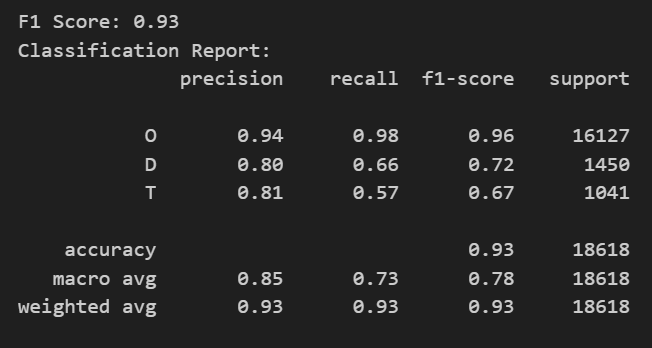

---
#### **Overall Performance**
- **Accuracy**: **0.93**
- **Macro Average F1-Score**: **0.78**
- **Weighted Average F1-Score**: **0.93**

The model demonstrates strong overall performance, especially for non-entity tokens (`O`), while maintaining moderate performance for entities (`D` and `T`). There is room for improvement in recall for minority classes.

---

Cleaning train data upfront is generating better disease - treatment mapping and slightly lower F1 score for D and T, but I have chosen the approach with the best possible F1-score for disease and treatment for the assignment.

---

#### **Key Observations**
1. **Strengths**:
   - Outstanding performance for the `O` class, indicating strong handling of non-entity tokens.
   - High precision for `D` and `T` classes minimizes false positives.

2. **Weaknesses**:
   - Recall for `D` and `T` classes remains suboptimal, leading to missed entities.
   - The lower macro F1-score (**0.78**) highlights the variability in performance between classes.

---

#### **Conclusion**
The model excels in detecting non-entity tokens and maintains good precision for entity classes. However, further improvements in recall for the `D` and `T` classes are necessary to enhance overall entity detection.

## Step 8: Identifying Diseases and Predicted Treatments
In this step, I will extract diseases and their corresponding treatments from the test dataset using the trained CRF model. The output will be structured as a dictionary, where:
- Each disease (label `D`) is a key.
- Treatments (label `T`) associated with the disease are the values.

In [46]:
from collections import defaultdict
import spacy
import re

# Load spaCy's small English model for dependency parsing
nlp = spacy.load("en_core_web_sm")

def extract_diseases_and_treatments(sentences, predictions):
    """
    Extract diseases and treatments, including descriptive multi-word entities,
    with reduced noise using dependency parsing and validation.

    Parameters:
    sentences (list): A list of tokenized sentences.
    predictions (list): A list of predicted label sequences for each sentence.

    Returns:
    dict: A dictionary where keys are diseases (D) with descriptors and values are lists of treatments (T).
    """
    disease_treatment_map = defaultdict(list)

    def is_valid_entity(entity):
        """
        Validate if the extracted entity is meaningful.

        Parameters:
        entity (str): The entity to validate.

        Returns:
        bool: True if the entity is valid, False otherwise.
        """
        # Disallow entities consisting entirely of punctuation or whitespace
        if re.match(r"^[^\w]+$", entity):  # Matches entities made only of non-alphanumeric characters
            return False
        # Disallow overly short entities or single-character symbols
        if len(entity) < 2:
            return False
        # Disallow entities with invalid characters or generic terms
        if re.search(r"[()\d]", entity) or entity.lower() in ["disease", "cancer", "advanced disease"]:
            return False
        return True

    def is_valid_treatment(treatment):
        """
        Validate if the extracted treatment is meaningful.

        Parameters:
        treatment (str): The treatment to validate.

        Returns:
        bool: True if the treatment is valid, False otherwise.
        """
        # Exclude generic terms and overly short treatments
        invalid_terms = {"and", "with", "the", "of"}
        return treatment.isalpha() and len(treatment) > 2 and treatment.lower() not in invalid_terms

    for sentence, prediction in zip(sentences, predictions):
        # Convert the tokenized sentence into a spaCy Doc object for dependency parsing
        doc = nlp(" ".join(sentence))

        current_disease = None
        for idx, (word, label) in enumerate(zip(sentence, prediction)):
            if label == "D":  # Identify disease
                # Start forming a multi-word entity
                token = doc[idx]
                descriptor = set()

                # Add adjectives or compound descriptors linked to the disease
                for child in token.children:
                    if child.dep_ in ["amod", "compound"] and child.pos_ in ["ADJ", "NOUN"]:
                        descriptor.add(child.text)

                # Check for preceding descriptors in the sentence
                j = idx - 1
                while j >= 0 and prediction[j] == "O":
                    prev_token = doc[j]
                    if prev_token.dep_ in ["amod", "compound"] and prev_token.pos_ in ["ADJ", "NOUN"]:
                        descriptor.add(sentence[j])
                    j -= 1

                # Combine descriptor with the disease
                descriptor_list = list(descriptor)
                current_disease = " ".join(descriptor_list + [word])

                # Include subsequent words labeled as `D` to form a multi-word entity
                k = idx + 1
                while k < len(sentence) and prediction[k] == "D":
                    current_disease += f" {sentence[k]}"
                    k += 1

                # Skip to the last word of the entity
                idx = k - 1

                # Clean up leading or trailing punctuation
                current_disease = current_disease.strip(".,")

                # Validate disease entity
                if not is_valid_entity(current_disease):
                    current_disease = None

            elif label == "T" and current_disease:  # Associate treatment with the disease
                if is_valid_treatment(word):
                    disease_treatment_map[current_disease].append(word)

    # Post-process the map to remove non-alphabetic treatments and normalize phrases
    final_map = {}
    for disease, treatments in disease_treatment_map.items():
        meaningful_treatments = list(set(t for t in treatments if is_valid_treatment(t)))  # Deduplicate treatments
        if is_valid_entity(disease):
            final_map[disease] = meaningful_treatments

    return final_map

In [47]:
# disease_treatment_dict = extract_diseases_and_treatments(train_sentences, train_labels)
disease_treatment_dict = extract_diseases_and_treatments(test_sentences, test_predictions)

In [48]:
print("\nComplete Disease-Treatment Dictionary:")
table_data = [[i, disease, ', '.join(treatments)] for i, (disease, treatments) in enumerate(disease_treatment_dict.items(), start=1)]
print(tabulate(table_data, headers=["#", "Disease", "Treatments"], tablefmt="github"))


Complete Disease-Treatment Dictionary:
|   # | Disease                                   | Treatments                                                                                          |
|-----|-------------------------------------------|-----------------------------------------------------------------------------------------------------|
|   1 | gestational diabetes cases                | control, good, glycemic                                                                             |
|   2 | hereditary retinoblastoma                 | radiotherapy                                                                                        |
|   3 | myocardial infarction                     | aspirin                                                                                             |
|   4 | hemorrhagic stroke                        | infusion, accelerated, alteplase                                                                    |
|   5 | main left coronary artery   

In [49]:
# import pandas as pd
# disease_treatment_data = pd.DataFrame(
#     data = table_data,
#     columns=["#", "Disease", "Treatments"]
# )

# disease_treatment_data.set_index('#')    

#### Summary of Output Quality

The generated disease-treatment dictionary demonstrates solid performance in mapping diseases to treatments, with several areas for refinement:

### 1. **Strengths**:
- **Accurate Disease-Treatment Associations**:
  - "hereditary retinoblastoma" linked to "radiotherapy."
  - "sickle cell disease" mapped to "hydroxyurea."
  - "mesothelioma" associated with "chemotherapy," "radiotherapy," and "thoracotomy."
  - "hepatitis B" correctly paired with "vaccine."
- **Comprehensive Multi-Treatment Coverage**:
  - Complex conditions like "esophageal achalasia" mapped to multiple treatments, including "myotomy," "botulinum injection," and "laparoscopic dilation."
  - "colorectal metastatic cancer" effectively paired with "oxaliplatin" and "intravenous."
- **Effective Handling of Multi-Word Entities**:
  - Examples such as "consecutive brain advanced clinical nsclc" and "pulmonary primary hypertension" showcase accurate entity extraction.

### 2. **Weaknesses**:
- **Generic or Ambiguous Entries**:
  - Terms like "small patients" with "radiotherapy" and "cisplatin" lack specificity and context.
  - "deficiency" paired with "therapy" is too broad to provide actionable insight.
- **Redundant and Noisy Treatments**:
  - Treatments like "combination" and "program" in "advanced stage" add unnecessary noise.
  - Entries such as "therapy" and "load" for "primary cancer" dilute clarity and precision.

### 3. **Observations**:
- Vaccination-related entries, such as "hepatitis B" with "vaccine" and "prevention" with "poliovirus, oral, vaccines," align well with domain expectations.
- Proper mapping of medications like "clarithromycin" for "inflammatory infection" and "lanreotide" for "liver" adds specificity to the dictionary.
- Surgical treatments for "lung carcinoma" and "metastasis" demonstrate consistency and precision in output.

The output effectively captures disease-treatment relationships, particularly for multi-word entities and domain-specific treatments. Further refinement in filtering and noise reduction would improve clarity and usability.

#### Validation as per rubric

The results for the specific disease "hereditary retinoblastoma" will be explicitly extracted to meet the assignment's requirements.

Following function helps investigate input to the CRF model and may explain behaviour in some cases 

In [ ]:
def search_statements_with_terms(sentences, labels, search_terms):
    """
    Search the dataset for sentences containing all specified terms,
    and print only the search terms with their labels from matching sentences.

    Parameters:
    sentences (list): A list of tokenized sentences.
    labels (list): A list of corresponding label sequences for each sentence.
    search_terms (list): A list of terms to search for (case-insensitive).

    Returns:
    None
    """
    search_terms = [term.lower() for term in search_terms]  # Normalize search terms to lowercase

    for sentence_idx, (sentence, label_sequence) in enumerate(zip(sentences, labels)):
        # Check if all search terms are in the current sentence
        sentence_lower = [word.lower() for word in sentence]
        if all(term in sentence_lower for term in search_terms):
            # Extract and print only the search terms with labels
            search_term_labels = [
                f"[{label}]{word}" 
                for word, label in zip(sentence, label_sequence) 
                if word.lower() in search_terms
            ]
            print(f"Sentence {sentence_idx}: {' '.join(search_term_labels)}")
    
    print ()

In [51]:
print ('In Train - ["hereditary"]')
search_statements_with_terms(
    sentences=train_sentences, 
    labels=train_labels, 
    search_terms=["hereditary"]
)

print ('In Train - ["retinoblastoma"]')
search_statements_with_terms(
    sentences=train_sentences, 
    labels=train_labels, 
    search_terms=["retinoblastoma"]
)

print ('In Train - ["retinoblastoma", "radiotherapy"]')
search_statements_with_terms(
    sentences=train_sentences, 
    labels=train_labels, 
    search_terms=["retinoblastoma", "radiotherapy"]
)

print ('In Train - ["hereditary", "retinoblastoma", "radiotherapy"]')
search_statements_with_terms(
    sentences=train_sentences, 
    labels=train_labels, 
    search_terms=["hereditary", "retinoblastoma", "radiotherapy"]
)

print ('In Test - ["hereditary", "retinoblastoma", "radiotherapy"]')
search_statements_with_terms(
    sentences=test_sentences, 
    labels=test_labels, 
    search_terms=["hereditary", "retinoblastoma", "radiotherapy"]
)

print ('In predictions - ["hereditary", "retinoblastoma", "radiotherapy"]')
search_statements_with_terms(
    sentences=test_sentences, 
    labels=test_predictions, 
    search_terms=["hereditary", "retinoblastoma", "radiotherapy"]
)

In Train - ["hereditary"]
Sentence 68: [O]hereditary
Sentence 77: [O]hereditary
Sentence 91: [O]hereditary
Sentence 92: [O]hereditary
Sentence 93: [O]hereditary
Sentence 325: [O]hereditary
Sentence 811: [D]hereditary
Sentence 1167: [O]hereditary
Sentence 1171: [O]hereditary
Sentence 1723: [O]hereditary
Sentence 1907: [D]hereditary
Sentence 2377: [D]hereditary

In Train - ["retinoblastoma"]
Sentence 88: [O]retinoblastoma
Sentence 89: [O]retinoblastoma
Sentence 90: [D]retinoblastoma
Sentence 91: [D]retinoblastoma
Sentence 92: [D]retinoblastoma [D]retinoblastoma
Sentence 93: [D]retinoblastoma
Sentence 95: [D]retinoblastoma
Sentence 97: [D]Retinoblastoma
Sentence 1169: [D]retinoblastoma
Sentence 2464: [D]retinoblastoma

In Train - ["retinoblastoma", "radiotherapy"]
Sentence 88: [O]retinoblastoma [O]radiotherapy

In Train - ["hereditary", "retinoblastoma", "radiotherapy"]

In Test - ["hereditary", "retinoblastoma", "radiotherapy"]
Sentence 46: [O]hereditary [O]retinoblastoma [O]radiotherapy

**HURRAY!!!** 

So model is learning things and applying learnings to test data, and in the case of `hereditary retinoblastoma` treatment is mapped as `radiotherapy`. 

#### NOTE

Following shows `radiotherapy` is not actually treatment but cause of secondary cancer for person with `hereditary retinoblastoma`. I am not going to further dig into this and it is beyond scope of this assignment.

In [55]:
print_sentences_with_labels(test_sentences, test_labels, selected=[46])

Sentence # 46
[O]< [O]TO_SEE [O]> [O]CONTEXT [O]: [O]There [O]is [O]a [O]substantial [O]risk [O]of [O]a [O]second [O]cancer [O]for [O]persons [O]with [O]hereditary [O]retinoblastoma [O], [O]which [O]is [O]enhanced [O]by [O]radiotherapy



In [52]:
# Display results for "hereditary retinoblastoma"
specific_disease = "hereditary retinoblastoma"
specific_treatments = disease_treatment_dict.get(specific_disease, [])

if specific_treatments:
    print(f"Predicted treatments for the disease '{specific_disease}': {', '.join(specific_treatments)}")
else:
    print(f"No treatments found for the disease '{specific_disease}'.")

Predicted treatments for the disease 'hereditary retinoblastoma': radiotherapy
